# Chemprop functions

## Setup

In [82]:
#|default_exp chemprop

In [84]:
# !pip install descriptastorus chemprop rdkit scipy -Uqq

In [85]:
#|export
import chemprop, pandas as pd, numpy as np
from MolCraft.utils import *

In [10]:
# if error import scipy gibrat
# !pip install scipy -U

# import scipy

# scipy.__version__

## Load Data

In [5]:
df = pd.read_csv('dataset/all2.csv')

In [6]:
df.head()

,ID,SMILES,Kd,IC50,erk_IC50
0,US_284,Oc1cc(Cl)c(C(F)(F)F)c(-c2ncc3c(N4CC5CCC(C4)N5)...,NaN,0.1,17.4
1,31678_45,C#Cc1c(F)ccc2cc(O)cc(-c3ncc4c(NCC5(N(C)C)CCC5)...,NaN,0.4,38.3
2,US_243,C#Cc1cccc2cc(O)cc(-c3ncc4c(N5CC6CCC(C5)N6)nc(O...,NaN,0.4,0.8
3,US_340,Oc1ccc(OC(F)(F)F)c(-c2ncc3c(N4CC5CCC(C4)N5)nc(...,NaN,0.4,51.5
4,US_439,C#Cc1c(F)ccc2cccc(-c3ncc4c(N5CC6CCC(C5)N6)nc(O...,NaN,0.4,12.8


In [7]:
df = preprocess_smi_df(df,'SMILES')

before processing: (1410, 5)
after processing: (1410, 5)


In [13]:
train = df[['SMILES','IC50']].dropna()

In [14]:
train.to_csv('train.csv', index=False)

## Function & Use

In [60]:
#| export
def train_file(train_file: str, # filename
               valid_file:str,
               test_file:str,
               task: str, # "regression" or "classification"
               ckp_folder: str = 'ckp', # checkpoint folder name
               epochs: int=30, # default for chemprop is 30
               seed: int = 0
               ):
    "Use Chemprop to train a file with first column as smiles, and the rest columns as target, with header row"
    
    assert task in ["regression","classification"], "task must be either 'regression' or 'classification'"
    
    arguments = [
    '--data_path', train_file,
    '--dataset_type', task,
    '--save_dir', ckp_folder,
    '--epochs', str(epochs),
    '--seed', str(seed),
    '--save_smiles_splits',
    '--quiet', #  quiet

    # extra metrics for classification
    # '--extra_metrics', 'prc-auc',

    # for splitting
    '--split_type', 'scaffold_balanced',


    # if customize split, need to indicate valid and test file
    # '--separate_val_path', valid_file,
    # '--separate_test_path', test_file,


    # for generating RDKit features, comment out if not needed
    # '--features_generator', 'rdkit_2d_normalized',
    # '--no_features_scaling'

    # alternatively, generate features in advance
    # '--features_path', <csv/npy file>, '--no_features_scaling'

    # if hyperopt before
    # '--config_path', <config path>
    ]

    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

    return mean_score,std_score

In [61]:
# To optimize model parameter, to use it in training, add it to --config_path in training
# !chemprop_hyperopt --data_path <input_file.csv> --dataset_type <reg./class.> --num_iters <10> --config_save_path <folder>

In [63]:
#| output: false
mean,_ = train_file('train.csv','train.csv','train.csv','regression',epochs=1)

1364it [00:00, 210208.36it/s]
100%|██████████| 1364/1364 [00:00<00:00, 160324.81it/s]
Fold 0
100%|██████████| 1364/1364 [00:00<00:00, 3243.45it/s]
0it [00:00, ?it/s]Warning: Repeated SMILES found in data, pickle file of split indices cannot distinguish entries and will not be generated.
175it [00:00, 170460.57it/s]
 86%|████████▋ | 19/22 [00:00<00:00, 29.37it/s]
                                               
  0%|          | 0/3 [00:00<?, ?it/s]
                                     /usr/local/lib/python3.9/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
Model 0 best validation rmse = 15487.036811 on epoch 0
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 

In [64]:
# To compare with original command
# !chemprop_train --data_path 'SAMPL.csv' --dataset_type 'regression' --save_dir 'ckp2' --epochs '10' --separate_val_path 'SAMPL.csv' --separate_test_path 'SAMPL.csv'

In [69]:
#| export
def predict_file(input_file:str, # filename, with first column as smiles
                 ckp_folder: str = 'ckp', # checkpoint folder name
                 return_df=True
                 ):

    "Load trained models and make predictions on csv file that contains SMILES in the first column"
    arguments = [
    '--test_path', input_file,
    '--preds_path', '/dev/null',
    '--checkpoint_dir', ckp_folder,

    # for generating RDKit features, comment out if not needed
    # '--features_generator', 'rdkit_2d_normalized', # for generating RDKit features
    # '--no_features_scaling',

    ]

    args = chemprop.args.PredictArgs().parse_args(arguments)
    preds = chemprop.train.make_predictions(args=args)

    preds = np.array(preds).squeeze()

    if return_df:
        preds = pd.DataFrame(preds)
        preds.columns = 'pred_'+preds.columns.astype(str)
        df = pd.read_csv(input_file)
        df = pd.concat([df,preds],axis=1)
        return df

    else:
        return preds

In [70]:
out = predict_file('ckp/fold_0/test_full.csv')

Loading training args
Setting molecule featurization parameters to default.
Loading data


137it [00:00, 127297.22it/s]
100%|██████████| 137/137 [00:00<00:00, 96884.11it/s]


Validating SMILES
Test size = 137


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

Saving predictions to /dev/null
Elapsed time = 0:00:01


In [71]:
out = out.rename(columns={'pred_0':'pred'})

In [72]:
out2 = out.set_index('SMILES').map(lambda x: np.log10(x))

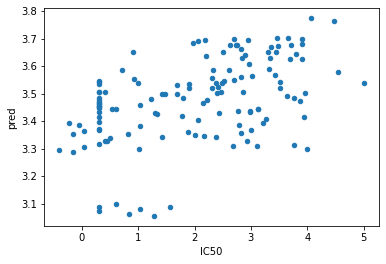

In [73]:
out2.plot.scatter('IC50','pred');

In [74]:
df= out.copy()

In [80]:
#| export
def predict_smiles(smiles: list,  # need to in format: [['CCC'], ['CCCC'], ['OCC']]
                   ckp_folder: str='ckp', # checkpoint folder name
                   ):

    "Load trained models and make predictions on list of SMILES"

    arguments = [
      '--test_path', '/dev/null',
      '--preds_path', '/dev/null',
      '--checkpoint_dir', ckp_folder,

      # for generating RDKit features
      # '--features_generator', 'rdkit_2d_normalized',
      # '--no_features_scaling'

      ]

    args = chemprop.args.PredictArgs().parse_args(arguments)
    model_objects = chemprop.train.load_model(args=args)

    preds = chemprop.train.make_predictions(args=args, smiles=smiles, model_objects=model_objects)

    return preds

In [76]:
smi_list = []
for s in df.SMILES:
    smi_list.append([preprocess_smiles(s)])

In [77]:
pred2 = predict_smiles(smi_list)

Loading training args
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 137


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

Saving predictions to /dev/null
Elapsed time = 0:00:01


In [78]:
df['pred2'] = np.array(pred2).squeeze()

In [79]:
df

,SMILES,IC50,pred,pred2
0,C#Cc1c(F)ccc2cc(O)cc(-c3ncc4c(NCC5(N(C)C)CCC5)...,0.4,1976.685427,1976.685427
1,CCc1cccc2cccc(-c3ncc4c(NCC5(N(C)C)CCC5)nc(OC[C...,59.2,2629.022829,2629.022829
2,NC1(CNc2nc(OC[C@@]34CCCN3C[C@H](F)C4)nc3c(F)c(...,62.8,3049.582755,3049.582755
3,C#Cc1cccc2cc(O)cc(-c3ncc4c(NCC5(N(C)C)CCC5)nc(...,0.6,2477.608778,2477.608778
4,CN(C)C1(CNc2nc(OC[C@@]34CCCN3C[C@H](F)C4)nc3c(...,582.9,2743.045784,2743.045784
...,...,...,...,...
132,CN1CCC[C@H]1COc1nc(N2CC3CCC2CN3)c2cnc(-c3cc(O)...,49.4,3393.805075,3393.805075
133,NC1CC(Nc2nc(OCC34CCCN3CCC4)nc3c(F)c(-c4cccc5cc...,202.7,3324.763734,3324.763734
134,CN1CC[C@H](COc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc...,262.6,3343.646612,3343.646612
135,CCc1c(F)ccc2cc(O)cc(-c3ncc4c(NCC5CCNC5=O)nc(OC...,4.0,2791.125239,2791.125239


We got the same results as pred

## Model interpretation

In [8]:
# property_id is the number of property in a csv; 1 means the first target property in the df
# !chemprop_interpret --data_path <csv file name> --checkpoint_dir <tox21_checkpoints/fold_0/> --property_id 1

In [9]:
# Train
# !chemprop_train --data_path <path> --dataset_type <classifcation/regression> --save_dir <ckp_folder>

In [86]:
#| hide
import nbdev; nbdev.nbdev_export()